In [4]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
import copy
import sys, os
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.metrics import r2_score
from scipy.io import savemat
np.set_printoptions(linewidth=500)

# Noise가 X에 dependent 하다고 가정하고 CGAN 학습하는 코드
# P-type 만 가지고 .. 

In [5]:
seed = 0

# excel file 보고 값 기입
n_of_cycle = 270 # 조합 갯수 : n_of_cycle
n_in_cycle = 10 # random variation 갯수

In [6]:
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
np.random.seed(seed)
#random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [9]:
def load_data(path, sheet_name, num_of_cycle, num_in_cycle):
    
    num_total = num_of_cycle*num_in_cycle
    
    X_dim = 4
    x_df = pd.read_excel(path, sheet_name=sheet_name, header=2, usecols="D:G", nrows=num_total+1)
    
    X_per_cycle = np.zeros((num_of_cycle, X_dim)) 
    for i in range(num_of_cycle):
        X_per_cycle[i] = x_df[i*num_in_cycle+1:i*num_in_cycle+2].values
    X_total = np.repeat(X_per_cycle,num_in_cycle,axis=0)
    
    
    #-------------------------------------------------------------------------------
    Y_dim = 6
    y_df = pd.read_excel(path, sheet_name=sheet_name, header=2, usecols="K:P", nrows=num_total+1)

    Y_total = np.zeros((num_of_cycle*num_in_cycle, Y_dim))
    for i in range(num_of_cycle*num_in_cycle):
        Y_total[i] = y_df[i+1:i+2].values
    
    return (X_per_cycle, X_total, Y_total)

In [10]:
# 파일로부터 데이터불러오기

X_per_cycle, X_total, Y_total= load_data(path='./LER_data_20191125.xlsx', sheet_name='uniformly sampling', num_of_cycle=n_of_cycle, num_in_cycle=n_in_cycle)
print(X_per_cycle.shape, X_total.shape, Y_total.shape)

X_data = copy.deepcopy(X_total)
print(X_data.shape)

y_data = copy.deepcopy(Y_total)
print(y_data.shape)
print('y값 nan 있는 곳 있나? : ', np.argwhere(np.isnan(y_data)))

(270, 4) (2700, 4) (2700, 6)
(2700, 4)
(2700, 6)
y값 nan 있는 곳 있나? :  []


In [11]:
X_total.shape

(2700, 4)

In [12]:
# 1. mean 예측하는 모델만들어야함.
y_mean = np.mean(np.split(y_data, n_of_cycle), axis = 1)
#y_std = np.std(np.split(y_data, n_of_cycle), axis = 1)
print(y_mean.shape)

# just check
print(np.min(y_mean,axis=0))
print(np.max(y_mean,axis=0))

(270, 6)
[5.0861e-12 3.7404e-12 2.9580e-01 3.0680e-01 3.7574e-05 1.5875e-05]
[9.4554e-12 6.2493e-12 3.0970e-01 3.1880e-01 4.0090e-05 1.7356e-05]


In [13]:
# Y-Y_mean을 통해 noise만 만들어낼꺼임.. shape 맞추기
y_mean_expanded = np.repeat(y_mean, n_in_cycle, axis=0)
noise_total = y_data - y_mean_expanded

## Data Split

In [14]:
# cycle을 split하자
train_num = 230
val_num = 20
test_num = 20

In [15]:
#데이터 스플릿
X_train = X_data[:train_num]
X_val = X_data[train_num:train_num+val_num]
X_test = X_data[train_num+val_num: train_num + val_num + test_num]

y_train = y_data[:train_num*n_in_cycle]
y_val = y_data[train_num*n_in_cycle:(train_num+val_num)*n_in_cycle]
y_test = y_data[(train_num+val_num)*n_in_cycle : (train_num + val_num + test_num)*n_in_cycle]

y_mean_train = y_mean[:train_num]
y_mean_val = y_mean[train_num:train_num+val_num]
y_mean_test = y_mean[train_num+val_num: train_num + val_num + test_num]

print(len(X_train), len(X_val), len(X_test))
print(len(y_mean_train), len(y_mean_val), len(y_mean_test))

noise_train = noise_total[:train_num*n_in_cycle]
noise_val = noise_total[train_num*n_in_cycle:(train_num+val_num)*n_in_cycle]
noise_test = noise_total[(train_num+val_num)*n_in_cycle: (train_num + val_num + test_num)*n_in_cycle]

230 20 20
230 20 20


# Data Visualization

In [16]:
# 정규화 계수 구하기
#params = (np.min(y_mean_var_train, axis=0), np.max(y_mean_var_train, axis=0))
tr_x_mean = np.mean(X_train, axis=0, dtype=np.float32) 
tr_x_std = np.std(X_train, axis=0, dtype=np.float32)
tr_y_mean = np.mean(y_mean_train, axis=0, dtype=np.float32) 
tr_y_std = np.std(y_mean_train, axis=0, dtype=np.float32)
print(tr_x_mean, tr_x_std)
print(tr_y_mean, tr_y_std)
#tr_y_mean[0:6] = np.mean(y_data[:2300], axis=0, dtype=np.float32) 
#tr_y_std[0:6] = np.std(y_data[:2300], axis=0, dtype=np.float32)
#print(tr_x_mean, tr_x_std)
#print(tr_y_mean, tr_y_std)

# 데이터 정규화
X_train_normalized = (X_train - tr_x_mean) / tr_x_std
X_val_normalized = (X_val - tr_x_mean) / tr_x_std
X_test_normalized = (X_test - tr_x_mean) / tr_x_std
y_mean_train_normalized = (y_mean_train - tr_y_mean) / tr_y_std
y_mean_val_normalized = (y_mean_val - tr_y_mean) / tr_y_std
y_mean_test_normalized = (y_mean_test - tr_y_mean) / tr_y_std

# y_mean_var_train_norm = normalizing(y_mean_var_train, params)
# y_mean_var_val_norm = normalizing(y_mean_var_val, params)

[ 0.4730876 19.795668  49.552162   1.0318342] [0.24371713 2.7305803  2.9096346  0.05946118]
[7.2971369e-12 5.1014410e-12 3.0103168e-01 3.1105992e-01 3.9182523e-05 1.6813887e-05] [7.1737722e-13 4.3076369e-13 2.6109116e-03 2.2923418e-03 5.8644594e-07 3.2114050e-07]


In [17]:
# tensor로..
print(X_train_normalized.shape)
print(y_mean_train_normalized.shape)
X_train_normalized = torch.tensor(X_train_normalized).float()
X_val_normalized = torch.tensor(X_val_normalized).float()
y_mean_train_normalized = torch.tensor(y_mean_train_normalized).float()
y_mean_val_normalized = torch.tensor(y_mean_val_normalized).float()

train_dataset = TensorDataset(X_train_normalized, y_mean_train_normalized)
val_dataset = TensorDataset(X_val_normalized, y_mean_val_normalized)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

(230, 4)
(230, 6)


In [18]:
X_test_normalized = torch.tensor(X_test_normalized).float()

In [19]:
#output inverse 연산 (최종 예측한 Y_mean)
print(tr_x_mean)
print(tr_x_std)
print(tr_y_mean)
print(tr_y_std)

mean_output = output*tr_y_std + tr_y_mean            #(tr_max - tr_min) + tr_min

[ 0.4730876 19.795668  49.552162   1.0318342]
[0.24371713 2.7305803  2.9096346  0.05946118]
[7.2971369e-12 5.1014410e-12 3.0103168e-01 3.1105992e-01 3.9182523e-05 1.6813887e-05]
[7.1737722e-13 4.3076369e-13 2.6109116e-03 2.2923418e-03 5.8644594e-07 3.2114050e-07]


NameError: name 'output' is not defined

In [18]:
class Net(nn.Module):
    def __init__(self, hidden_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 6)
        
    def forward(self, x):
        input_x = x
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        #x=F.dropout(x, training=self.training)
        x=self.fc4(x)
        return x
    
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)

In [21]:
def train(model, train_loader, val_loader, optimizer, scheduler, epochs=100, verbose=True):
    criterion = torch.nn.MSELoss()
    #optimizer = optim.SGD(model.parameters(), lr = 0.00001)
    train_loss_list = []
    val_loss_list = []
    r2_score_list = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_num=0
        for i, data in enumerate(train_loader):
            train_x, train_y = data
            train_x, train_y = train_x.cuda(), train_y.cuda()
            
            optimizer.zero_grad()
            output = model(train_x)
            loss = criterion(output, train_y) #순서맞음
            loss.backward()
            optimizer.step()
            train_loss += loss
            
            train_num += len(train_y)
            
        
        
        model.eval()
        val_loss = 0.0
        val_num = 0
        
        val_target = torch.tensor([]).float().cuda()
        val_pred = torch.tensor([]).float().cuda()
        
        for i, data in enumerate(val_loader):
            val_out=[]
            with torch.no_grad():
                val_x, val_y = data
                val_x, val_y = val_x.cuda(), val_y.cuda()
                
                val_output = model(val_x)
                val_loss += criterion(val_output, val_y)

                val_target = torch.cat((val_target, val_y))
                val_pred = torch.cat((val_pred, val_output))
                
                val_num += len(val_y)

        
        
        train_loss /= train_num
        val_loss /= val_num   
        r2 = r2_score(val_target.cpu().numpy(), val_pred.cpu().numpy()) # 순서맞음
        
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        r2_score_list.append(r2)
        
        for param_group in optimizer.param_groups:  #scheduler
            lr = param_group['lr']
            #print('lr_schedule:',lr)
        scheduler.step()
        
        if verbose==True :
            if((epoch+1)% 10 == 0):
                print("epoch:{:2d}, lr:{:.6f}, || train_loss:{:.6f}, val_loss:{:.6f}, r2_score:{:.6f}"
              .format(epoch, lr, train_loss, val_loss, r2))
    
    if verbose==False :        
        print("final results : epoch:{:2d}, lr:{:.6f}, || train_loss:{:.6f}, val_loss:{:.6f}, r2_score:{:.6f}"
              .format(epoch, lr, train_loss, val_loss, r2))        
    return model, train_loss_list, val_loss_list, r2_score_list
    
            

In [22]:
model = Net(hidden_dim=100)
model.apply(init_normal)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr = 5e-5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5) # scheduler
model, train_loss_list, val_loss_list, r2_scores = train(model, train_loader, val_loader,optimizer, exp_lr_scheduler, 
                                                         epochs=1000, verbose=True)

epoch: 9, lr:0.000050, || train_loss:0.064943, val_loss:0.056496, r2_score:-0.113799
epoch:19, lr:0.000050, || train_loss:0.048481, val_loss:0.049773, r2_score:0.064610
epoch:29, lr:0.000050, || train_loss:0.037660, val_loss:0.051211, r2_score:0.057546
epoch:39, lr:0.000050, || train_loss:0.036438, val_loss:0.052867, r2_score:0.030479
epoch:49, lr:0.000050, || train_loss:0.033952, val_loss:0.053685, r2_score:0.013081
epoch:59, lr:0.000050, || train_loss:0.035051, val_loss:0.054269, r2_score:0.000168
epoch:69, lr:0.000050, || train_loss:0.031554, val_loss:0.055427, r2_score:-0.026515
epoch:79, lr:0.000050, || train_loss:0.031651, val_loss:0.055242, r2_score:-0.022860
epoch:89, lr:0.000050, || train_loss:0.029920, val_loss:0.055671, r2_score:-0.034271
epoch:99, lr:0.000050, || train_loss:0.030367, val_loss:0.055975, r2_score:-0.038508
epoch:109, lr:0.000025, || train_loss:0.031062, val_loss:0.056151, r2_score:-0.044029
epoch:119, lr:0.000025, || train_loss:0.030974, val_loss:0.056172, r2

epoch:969, lr:0.000000, || train_loss:0.029787, val_loss:0.058300, r2_score:-0.090147
epoch:979, lr:0.000000, || train_loss:0.031793, val_loss:0.058300, r2_score:-0.090143
epoch:989, lr:0.000000, || train_loss:0.030974, val_loss:0.058300, r2_score:-0.090147
epoch:999, lr:0.000000, || train_loss:0.032574, val_loss:0.058300, r2_score:-0.090149


# Generate Noise with GAN

In [23]:
def sample_z(batch_size = 1, d_noise=100):    # latent dim 크기를 가지는 가우시안 노이즈 벡터를 배치수만큼의 갯수로 추출하는 함수.
    return torch.randn(batch_size, d_noise).cuda()

In [24]:
class G(nn.Module):
    def __init__(self, d_noise, d_hidden, dim_output):
        super(G, self).__init__()
        self.fc1 = nn.Linear(d_noise, d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_hidden)
        self.fc3 = nn.Linear(d_hidden, dim_output)

    def forward(self, x):
        input_x = x
        x=F.relu(self.fc1(x))
        #x=F.dropout(x, p=0.1)
        x=F.relu(self.fc2(x))
        #x=F.dropout(x, p=0.1)
        x=self.fc3(x)
        output = x
        return x
    
    
class D(nn.Module):
    def __init__(self, dim_output, d_hidden):
        super(D, self).__init__()
        self.fc1 = nn.Linear(dim_output, d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_hidden)
        self.fc3 = nn.Linear(d_hidden, 1)
        

    def forward(self, x):
        input_x = x
        x=F.relu(self.fc1(x))
        #x=F.dropout(x, p=0.1)
        x=F.relu(self.fc2(x))
        #x=F.dropout(x, p=0.1)
        x=torch.sigmoid(self.fc3(x))
        output = x
        return x

In [25]:
dim_input = 10
dim_output = 6
d_hidden = 10

#CONDITIONAL
G = G(dim_input+4, d_hidden, dim_output).cuda()
D = D(dim_output+4, d_hidden).cuda()

In [ ]:
# GANs 학습에 사용되는 함수


def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d, train_data_loader):
    
    generator.train()
    discriminator.train()

    for real_batch, X_batch in train_data_loader:
        real_batch, X_batch = real_batch.cuda(), X_batch.cuda()
        
        batch_size=len(real_batch)
        
        input_for_D = torch.cat((real_batch, X_batch),axis=1)
        input_for_G = torch.cat((sample_z(batch_size, dim_input),X_batch),axis=1)
        
        p_real = discriminator(input_for_D)
        p_fake = discriminator(torch.cat((generator(input_for_G), X_batch),axis=1))


        loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        loss_d    = (loss_real + loss_fake).mean() # 배치에 대해 mean
        
        
        # Update parameters
        _optimizer_d.zero_grad() #grad 계산 전 항상 init 해주기
        loss_d.backward() # grad 계산
        _optimizer_d.step() # update

        
        input_for_G = torch.cat((sample_z(batch_size, dim_input),X_batch),axis=1)
        p_fake = discriminator(torch.cat((generator(input_for_G), X_batch),axis=1))
                
        # instead of: torch.log(1.-p_fake).mean() <- explained in Section 3
        loss_g = -1 * torch.log(p_fake).mean()  # log(D(G(z)))를 maximize 하는 것으로 (초기 D의 overpower 문제 해결위해)
        
        # Update parameters
        _optimizer_g.zero_grad() #grad 계산 전 항상 init 해주기
        loss_g.backward() #grad 계산
        _optimizer_g.step()
          
def evaluate_model(generator, discriminator, test_data_loader):
    
    p_real, p_fake = 0.,0.
    
    generator.eval() # 모드 변경
    discriminator.eval() # 모드 변경
    
    batch_num=0
    for real_batch, X_batch in test_data_loader:
        
        real_batch, X_batch = real_batch.cuda(), X_batch.cuda()
        batch_size = len(real_batch)
        
        with torch.autograd.no_grad():
            input_for_D = torch.cat((real_batch,X_batch),axis=1)
            input_for_G = torch.cat((sample_z(batch_size, dim_input),X_batch),axis=1)
            p_real += torch.sum(discriminator(input_for_D)).item()/len(real_batch)
            p_fake += torch.sum(discriminator(torch.cat((generator(input_for_G), X_batch),axis=1))).item()/len(real_batch)
            
        batch_num += 1
    p_real /= batch_num
    p_fake /= batch_num
    return p_real, p_fake

In [27]:
tr_noise_mean = np.mean(noise_train, axis=0, dtype=np.float32) 
tr_noise_std = np.std(noise_train, axis=0, dtype=np.float32)

In [28]:
noise_train_normalized = (noise_train-tr_noise_mean)/tr_noise_std
noise_val_normalized = (noise_val-tr_noise_mean)/tr_noise_std
noise_test_normalized = (noise_test-tr_noise_mean)/tr_noise_std

In [29]:
train_dataset_GAN = TensorDataset(torch.tensor(noise_train_normalized).float(),torch.tensor(np.repeat(X_train_normalized.numpy(), 10, axis=0)).float())
val_dataset_GAN = TensorDataset(torch.tensor(noise_val_normalized).float(),torch.tensor(np.repeat(X_val_normalized.numpy(), 10, axis=0)).float())

train_loader_GAN = DataLoader(train_dataset_GAN, batch_size = 64, shuffle = True)
val_loader_GAN = DataLoader(val_dataset_GAN, batch_size = 64, shuffle = False)

In [30]:
optimizer_g = torch.optim.Adam(G.parameters(), lr = 0.0001)
optimizer_d = torch.optim.Adam(D.parameters(), lr = 0.0005)

p_real_trace = []
p_fake_trace = []

In [31]:
def init_params(model): # weight initialization 인듯
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)   

init_params(G)
init_params(D)

In [32]:
scheduler_GAN = lr_scheduler.StepLR(optimizer_d, step_size=50, gamma=0.5) # scheduler

for epoch in range(200):
    
    #print('epoch', epoch)
    
    run_epoch(G, D, optimizer_g, optimizer_d, train_loader_GAN)
    p_real, p_fake = evaluate_model(G, D, val_loader_GAN)
    
    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake) 
    
    
    for param_group in optimizer_d.param_groups:  #scheduler
        lr_d = param_group['lr']
        #print('lr_schedule:',lr)
    scheduler_GAN.step()
    
    
    if((epoch+1)% 10 == 0):
        print('epoch : (%i/200), lr_d:%.10f, p_real: %f, p_g: %f' % (epoch+1, lr_d, p_real, p_fake))

epoch : (10/200), lr_d:0.0005000000, p_real: 0.629210, p_g: 0.414907
epoch : (20/200), lr_d:0.0005000000, p_real: 0.678767, p_g: 0.311832
epoch : (30/200), lr_d:0.0005000000, p_real: 0.697371, p_g: 0.320847
epoch : (40/200), lr_d:0.0005000000, p_real: 0.653066, p_g: 0.350362
epoch : (50/200), lr_d:0.0005000000, p_real: 0.607039, p_g: 0.347804
epoch : (60/200), lr_d:0.0002500000, p_real: 0.549883, p_g: 0.425359
epoch : (70/200), lr_d:0.0002500000, p_real: 0.492391, p_g: 0.458964
epoch : (80/200), lr_d:0.0002500000, p_real: 0.479991, p_g: 0.469193
epoch : (90/200), lr_d:0.0002500000, p_real: 0.494314, p_g: 0.463600
epoch : (100/200), lr_d:0.0002500000, p_real: 0.493775, p_g: 0.483797
epoch : (110/200), lr_d:0.0001250000, p_real: 0.491189, p_g: 0.473371
epoch : (120/200), lr_d:0.0001250000, p_real: 0.483323, p_g: 0.503713
epoch : (130/200), lr_d:0.0001250000, p_real: 0.487281, p_g: 0.491001
epoch : (140/200), lr_d:0.0001250000, p_real: 0.490345, p_g: 0.481607
epoch : (150/200), lr_d:0.000

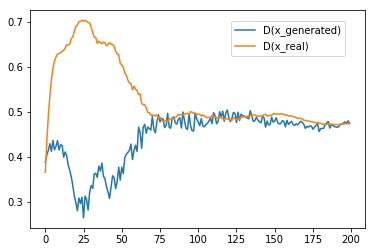

In [33]:
# epoch이 진행됨에 따라 D(x)와 D(G(z))의 확률값은 어떻게 개선되어 가는지?
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(0.60, 0.95), loc=2, borderaxespad=0.)

#plt.savefig(name+'_G&D_probability.png', dpi=300)
plt.show()


# Sample Generation

In [34]:
pred_train = model(X_train_normalized.cuda())
output_train = np.array(pred_train.tolist())
mean_output_train = output_train*tr_y_std + tr_y_mean

In [39]:
num_samples = 10
input_for_G = torch.cat((sample_z(len(noise_train)//10 * num_samples, dim_input), torch.from_numpy(np.repeat(X_train_normalized.numpy(), num_samples, axis=0)).cuda()),axis=1)
noise_train_normalized_predicted = G(input_for_G).detach().cpu().numpy()
noise_train_predicted = noise_train_normalized_predicted*tr_noise_std+tr_noise_mean

In [36]:
Y_train_predicted = np.repeat(mean_output_train,num_samples,axis=0)+noise_train_predicted

In [37]:
plt.figure(figsize = (0.1,0.1))
plt.style.use('default')
plt.plot(range(5),range(5))
plt.xticks(visible=False)
plt.yticks(visible=False)

(array([-2.5,  0. ,  2.5,  5. ]), <a list of 4 Text yticklabel objects>)

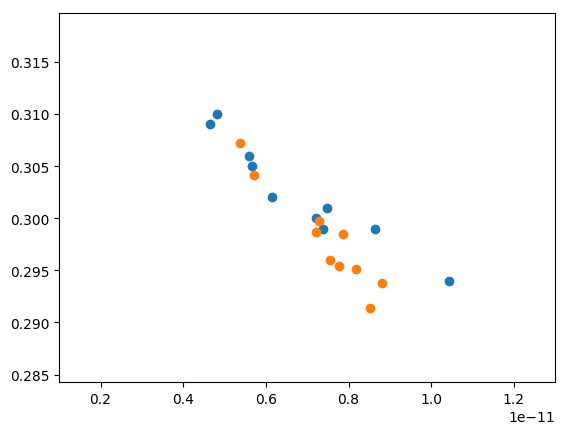

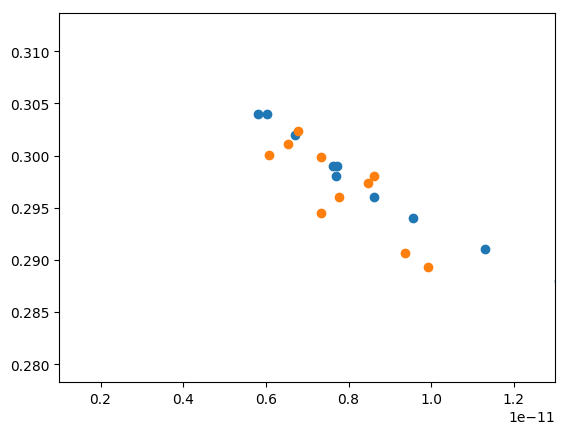

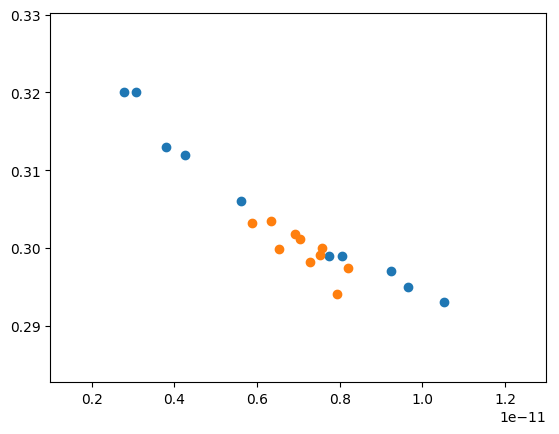

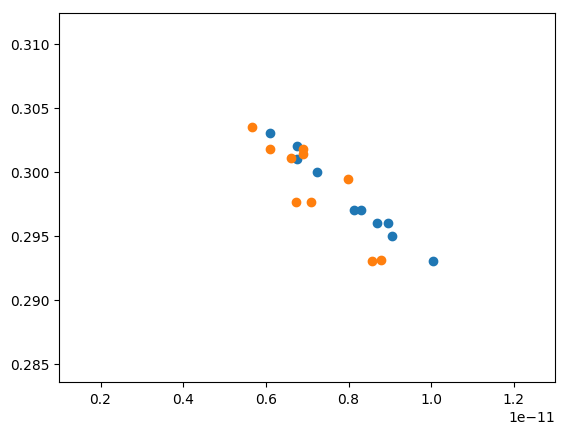

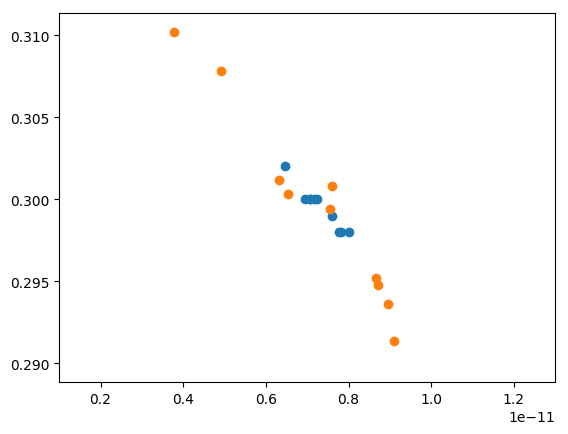

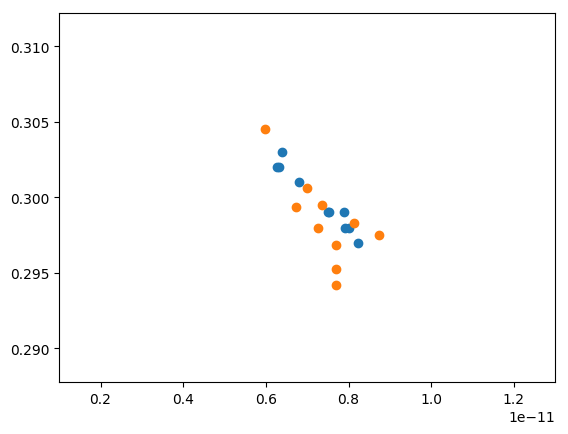

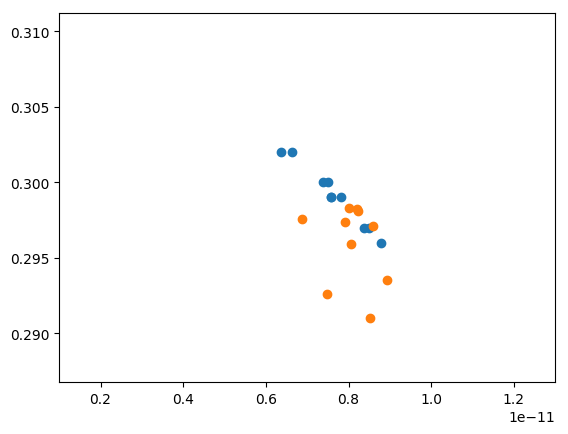

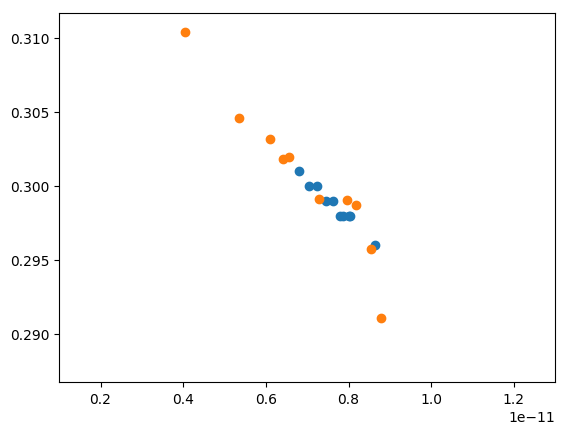

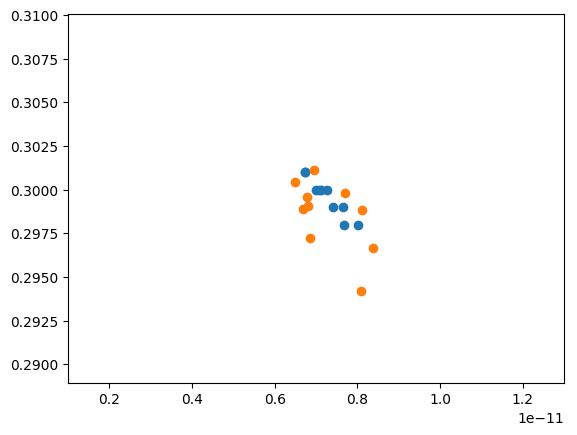

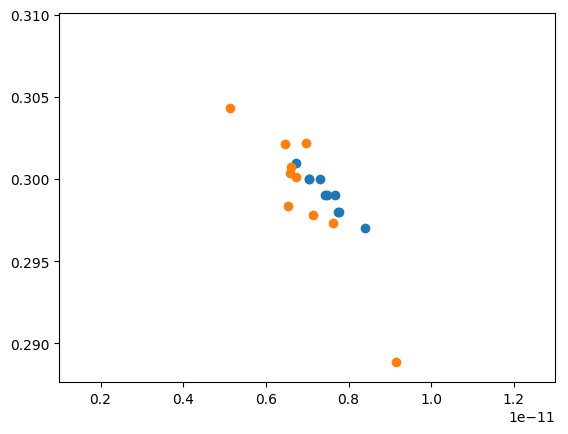

In [41]:
factor = num_samples // 10
for idx in range(10):
    start = 10 * idx
    end = 10 * (idx+1)

    plt.scatter(y_train[start:end,0],y_train[start:end,2])
    plt.scatter(Y_train_predicted[start*factor:end*factor,0],Y_train_predicted[start*factor:end*factor,2])
    plt.xlim(1e-12,13e-12)
    plt.show()

In [45]:
pred_test = model(X_test_normalized.cuda())
output_test = np.array(pred_test.tolist())
mean_output_test = output_test*tr_y_std + tr_y_mean

In [1]:
num_samples = 100
input_for_G = torch.cat((sample_z(len(noise_test)//10 * num_samples, dim_input), torch.from_numpy(np.repeat(X_test_normalized.numpy(), num_samples, axis=0)).cuda()),axis=1)
noise_test_normalized_predicted = G(input_for_G).detach().cpu().numpy()
noise_test_predicted = noise_test_normalized_predicted*tr_noise_std+tr_noise_mean

NameError: name 'torch' is not defined

In [61]:
Y_test_predicted = np.repeat(mean_output_test,num_samples,axis=0)+noise_test_predicted

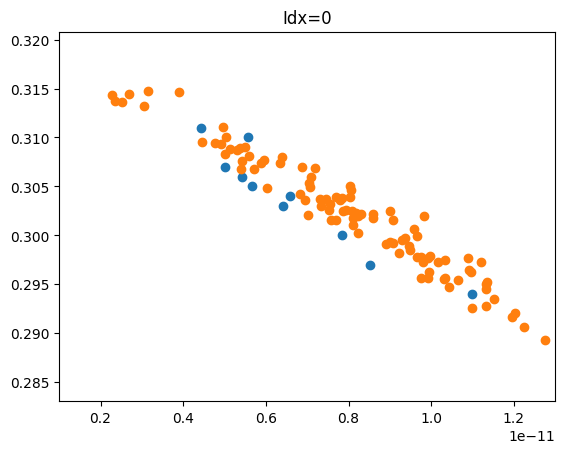

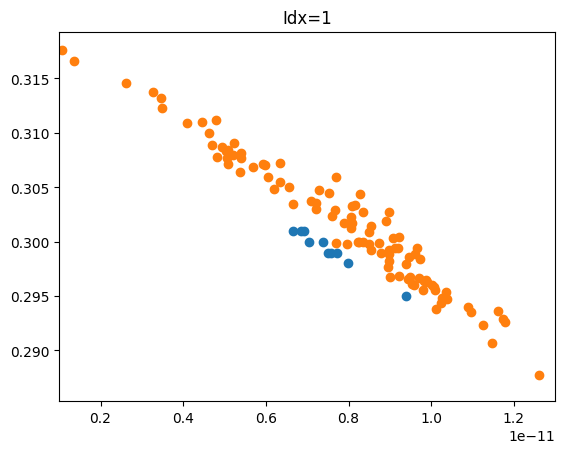

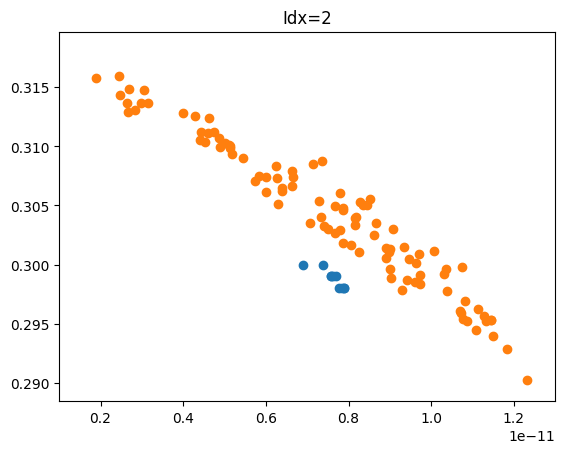

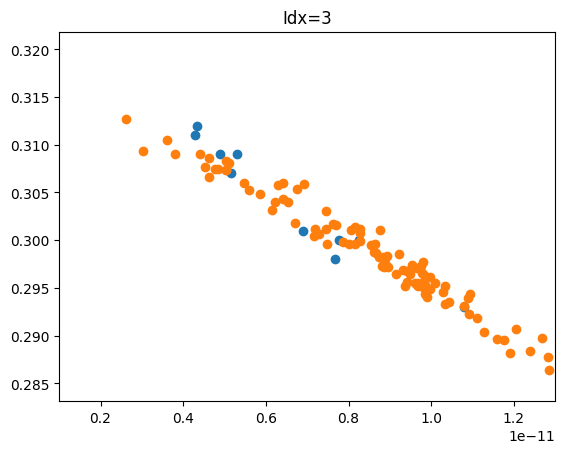

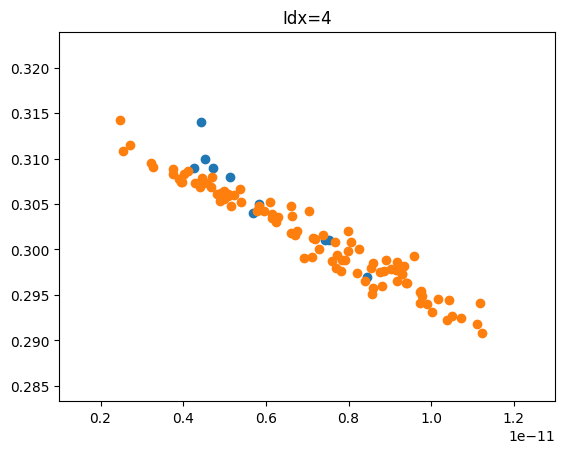

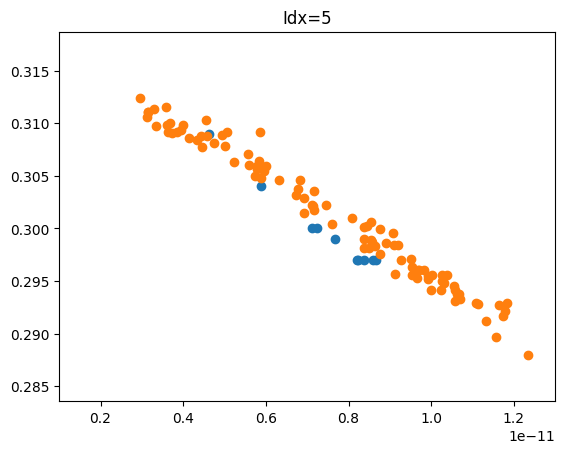

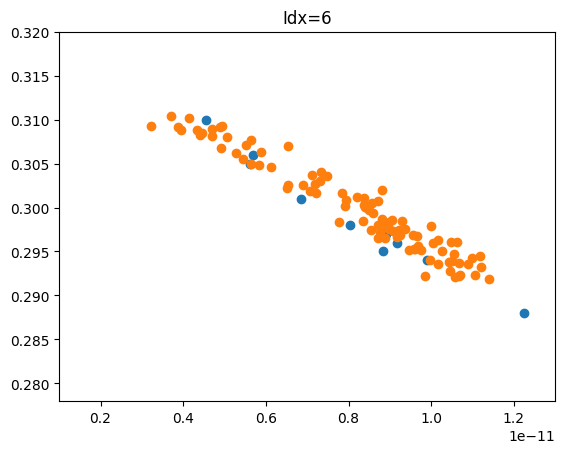

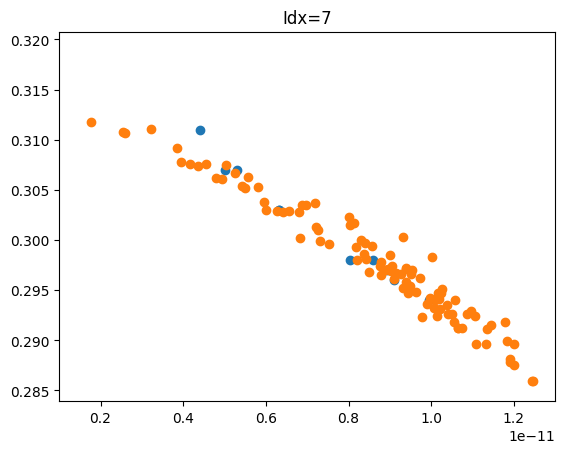

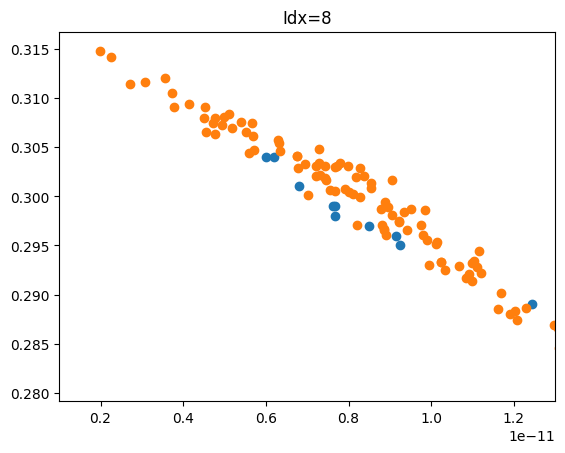

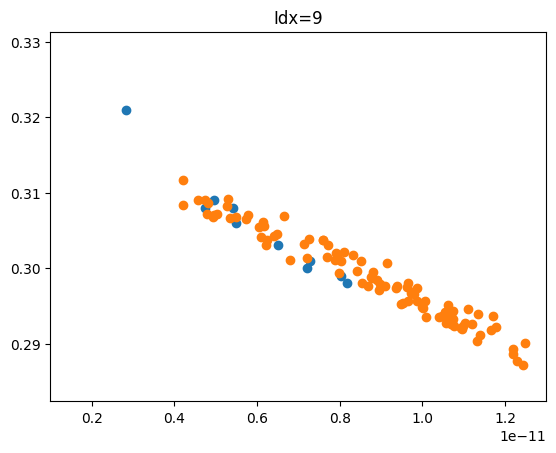

In [62]:
factor = num_samples // 10
for idx in range(10):
    start = 10 * idx
    end = 10 * (idx+1)

    plt.figure()
    plt.scatter(y_test[start:end,0],y_test[start:end,2])
    plt.scatter(Y_test_predicted[start*factor:end*factor,0],Y_test_predicted[start*factor:end*factor,2])
    plt.xlim(1e-12,13e-12)
    plt.title('Idx=%d'%idx)
    plt.show()

In [ ]:
plt.scatter(y_train[150:200,0],y_train[150:200,5])
plt.scatter(Y_train_predicted[150:200,0],Y_train_predicted[150:200,5])
plt.xlim(1e-12,13e-12)
plt.show()

In [ ]:
# V_T_sat
# I_off

In [ ]:
# Conditional VAE
# Bayesian Linear Regressison -> multivariate x
# Target을 mean, cov (9 by 9)


In [ ]:
# CGAN, WGAN
# infoGAN (실험 - attribute 바꿔보면서 의도대로 .. 각 attribute 잘 학습하지 않을까 ?)
# interpolation ..  